In [1]:
import tensorflow as tf
import numpy as np

from ACNet import ACNet
from FireFightingEnv import FFEnv

from tensorflow.python.client import device_lib

dev_list = device_lib.list_local_devices()
print(dev_list)

/home/peter/anaconda3/envs/course_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/peter/anaconda3/envs/course_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/peter/anaconda3/envs/course_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/peter/anaconda3/envs/course_env

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17790933386150550398
]


In [2]:
# __init__(self, observation_size=11, world0=None, goals0=None, DIAGONAL_MOVEMENT=False, SIZE=(10,40), PROB=(0,.5))
# TODO: add support of size, prob, etc, to initialize FFEnv Momnent lah
# Set agengt_num=1 for simplification. How to design a network support multi-agent? FIXED,follow idea 'batch'
agent_num = 3

env = FFEnv(agent_num=agent_num)

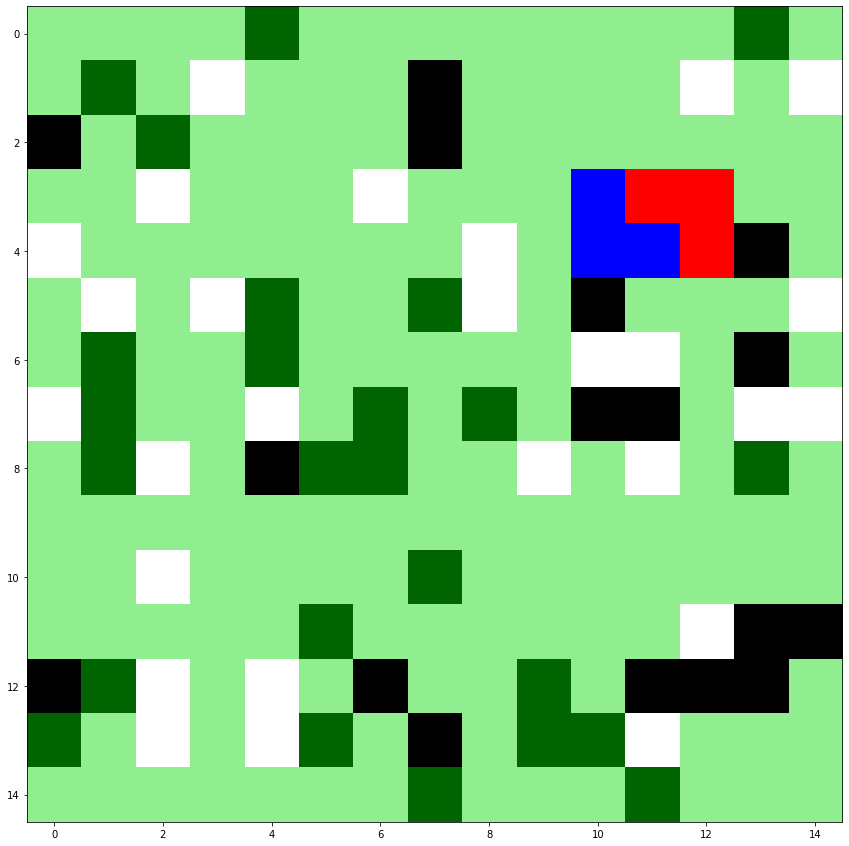

In [3]:
env.mapEnv.plotAll()

In [4]:
obs = np.array(env.observe_space)

# obstacle map of agent[0]
print(obs[0, 0], "\n")
# fire map of agent[0]
print(obs[0, 1], "\n")
# agent map of agent[0]
print(obs[0, 2], "\n")
# flammable map of agent[0]
print(obs[0, 3], "\n")
# reserved water of agent[0]
print(obs[0, 4], "\n")


[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.]
 [0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.]] 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0.

/home/peter/anaconda3/envs/course_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [5]:
# load data
# list & NumPy array, that's a question (re: array is the best)
inputs_raw = np.array(obs[:, :4])
inputs = []
for map in inputs_raw:
    reshaped_map = [np.array(arr) for arr in map]
    inputs.append(reshaped_map)
inputs = np.array(inputs)
print(inputs.shape)

water_res = np.array(obs[:, 4]).reshape(-1,1)
print(water_res.shape)

(3, 4, 11, 11)
(3, 1)


In [6]:
# action size: 4 direction movements, stop, 4 direction spraying with 5 kinds of range each direction
a_size = 5+4*5

trainer = tf.contrib.opt.NadamOptimizer(learning_rate=1e-4)

# __init__(self, scope, a, trainer, TRAINING, GRID_SIZE)
net = ACNet( "global", a_size, trainer, True, 11)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
QAQ! The network is working!


In [7]:
config = tf.ConfigProto()

sess = tf.Session(config=config)

sess.run(tf.global_variables_initializer()) # setting random weights for all layers of the network

In [8]:
rnn_state = net.state_init # (zeros(1,128), zeros(1,128))

feed_dict = {
    net.inputs: inputs,
    net.water_res: water_res,
    net.state_in[0]: rnn_state[0],
    net.state_in[1]: rnn_state[1],
}

policy = sess.run(net.policy, feed_dict = feed_dict)
print(policy)

[[0.03999085 0.03981172 0.04023175 0.04009644 0.04019327 0.03985499
  0.04003425 0.04000971 0.04005359 0.04001584 0.04006009 0.03992101
  0.04000583 0.03954796 0.04014407 0.03995515 0.04029475 0.03978802
  0.03984383 0.0399855  0.04002237 0.04026001 0.03990893 0.04000651
  0.03996345]
 [0.03991905 0.03970305 0.04037781 0.04018893 0.04032111 0.03975231
  0.0400355  0.03998668 0.04010408 0.04008972 0.04014078 0.03984502
  0.04003612 0.03927165 0.04023971 0.03991109 0.0404627  0.03964815
  0.03979082 0.03994759 0.04004739 0.04043224 0.03982173 0.03999462
  0.03993219]
 [0.03986954 0.03964576 0.04048575 0.04021185 0.04046544 0.03971361
  0.04002923 0.03999193 0.04012426 0.0400793  0.04013828 0.03977528
  0.04005517 0.03910769 0.04028532 0.03987864 0.04058619 0.03953281
  0.03974076 0.03996511 0.04003919 0.04057946 0.03976605 0.03997466
  0.0399587 ]]


In [52]:
state = env.reset()
episode_rollout = []

actions = []
for i in range(3):
    actions.append(dict())

for t in range(10):
    for a in actions:
        a[0] = np.random.choice([0, 1, 3, 3, 4])
        a[1] = np.random.choice([0, 1, 2, 3, 4, 5])
        a[2] = np.random.choice([0, 1, 2, 3, 4])
        a[3] = np.random.choice([0, 1])

    s1, rewards, done = env.step(actions)

    state = np.array(state)
    maps_raw = np.array(state[:, :4])
    maps = []
    for map in maps_raw:
        reshaped_map = [np.array(arr) for arr in map]
        maps.append(reshaped_map)
    maps = np.array(maps)
    
    water = np.array(state[:, 4]).reshape(-1,1)

    episode_rollout.append([maps, water, actions, rewards, actions])
    state = s1[:]

print(episode_rollout[0])

[array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.],
         ...,
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 1., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 1., 1., 1.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0.,

/home/peter/anaconda3/envs/course_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [58]:
inputs    = np.array([item[0] for item in episode_rollout])
water_res = np.array([item[1] for item in episode_rollout])
actions   = np.array([item[2] for item in episode_rollout])
rewards   = np.array([item[3] for item in episode_rollout])
valids    = np.array([item[4] for item in episode_rollout])
print(np.shape(inputs))
print(np.shape(water_res))
print(np.shape(actions))
print(actions)
print(np.shape(rewards))
print(rewards)

(10, 3, 4, 11, 11)
(10, 3, 1)
(10, 3)
[[{0: 1, 1: 2, 2: 0, 3: 1} {0: 3, 1: 0, 2: 1, 3: 0}
  {0: 3, 1: 3, 2: 1, 3: 1}]
 [{0: 1, 1: 2, 2: 0, 3: 1} {0: 3, 1: 0, 2: 1, 3: 0}
  {0: 3, 1: 3, 2: 1, 3: 1}]
 [{0: 1, 1: 2, 2: 0, 3: 1} {0: 3, 1: 0, 2: 1, 3: 0}
  {0: 3, 1: 3, 2: 1, 3: 1}]
 [{0: 1, 1: 2, 2: 0, 3: 1} {0: 3, 1: 0, 2: 1, 3: 0}
  {0: 3, 1: 3, 2: 1, 3: 1}]
 [{0: 1, 1: 2, 2: 0, 3: 1} {0: 3, 1: 0, 2: 1, 3: 0}
  {0: 3, 1: 3, 2: 1, 3: 1}]
 [{0: 1, 1: 2, 2: 0, 3: 1} {0: 3, 1: 0, 2: 1, 3: 0}
  {0: 3, 1: 3, 2: 1, 3: 1}]
 [{0: 1, 1: 2, 2: 0, 3: 1} {0: 3, 1: 0, 2: 1, 3: 0}
  {0: 3, 1: 3, 2: 1, 3: 1}]
 [{0: 1, 1: 2, 2: 0, 3: 1} {0: 3, 1: 0, 2: 1, 3: 0}
  {0: 3, 1: 3, 2: 1, 3: 1}]
 [{0: 1, 1: 2, 2: 0, 3: 1} {0: 3, 1: 0, 2: 1, 3: 0}
  {0: 3, 1: 3, 2: 1, 3: 1}]
 [{0: 1, 1: 2, 2: 0, 3: 1} {0: 3, 1: 0, 2: 1, 3: 0}
  {0: 3, 1: 3, 2: 1, 3: 1}]]
(10, 3)
[[-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]
 [-1. -1. -1.]]


In [12]:
# inputs    = rollout[:][0] # 10x3x11x11x4
# water_res = rollout[:,1] # 10x3x1
# actions   = rollout[:,2] # 10x3x1 FIXME!!!
# rewards   = rollout[:,3] # 10x3x1 FIXME!!!
# valids    = rollout[:,4] # 10x3x25 FIXME!!!


# In practice: calculate long-term cumulative discounted rewards from episode rewards here
# --> net.target_v

# In practice: calculate advantages estimates (TD-error) here
# --> net.advantages


rnn_state = net.state_init
feed_dict = {
    net.inputs:      np.stack(inputs),
    net.water_res:   np.stack(water_res),
    net.actions:     np.stack(actions),

    net.target_v:    np.stack(rewards),
    net.advantages:  np.stack(rewards),

    net.train_valid: np.stack(valids),
    net.state_in[0]: rnn_state[0],
    net.state_in[1]: rnn_state[1]
}

v_l, p_l, valid_l, g_n, _ = sess.run([net.value_loss,
                                      net.policy_loss,
                                      net.valid_loss,
                                      net.grad_norms,
                                      net.apply_grads], feed_dict=feed_dict)

print(v_l, p_l, valid_l, g_n)

/home/peter/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: setting an array element with a sequence.